In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 12ms/step - loss: 2.4936 - val_loss: 0.4419
Epoch 2/1000
136/136 - 0s - 3ms/step - loss: 0.3736 - val_loss: 0.3525
Epoch 3/1000
136/136 - 0s - 3ms/step - loss: 0.2636 - val_loss: 0.3601
Epoch 4/1000
136/136 - 0s - 3ms/step - loss: 0.2113 - val_loss: 0.3765
Epoch 5/1000
136/136 - 0s - 3ms/step - loss: 0.1745 - val_loss: 0.3926
Epoch 6/1000
136/136 - 0s - 3ms/step - loss: 0.1537 - val_loss: 0.4020
Epoch 7/1000
136/136 - 0s - 3ms/step - loss: 0.1295 - val_loss: 0.4249
Epoch 8/1000
136/136 - 0s - 3ms/step - loss: 0.1199 - val_loss: 0.4362
Epoch 9/1000
136/136 - 1s - 4ms/step - loss: 0.1043 - val_loss: 0.4230
Epoch 10/1000
136/136 - 0s - 3ms/step - loss: 0.1000 - val_loss: 0.4509
Epoch 11/1000
136/136 - 1s - 4ms/step - loss: 0.0919 - val_loss: 0.4344
Epoch 12/1000
136/136 - 1s - 4ms/step - loss: 0.0839 - val_loss: 0.4331
Epoch 12: early stopping
Epoch 1/1000
136/136 - 2s - 15ms/step - loss: 2.8278 - val_loss: 0.4612
Epoch 2/1000
136/136 - 1s - 4ms/step - loss: 0.

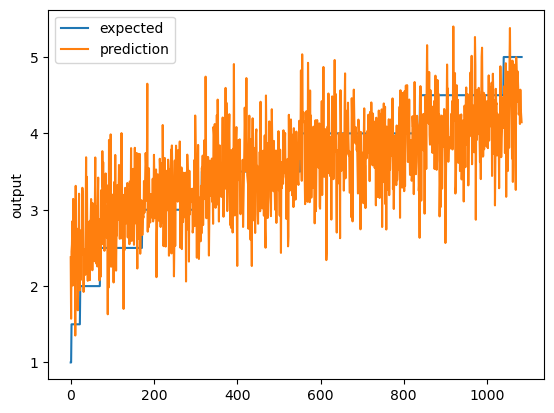

In [3]:
# Author: Nicolas Gugliemo 
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))


# Plot the chart
chart_regression(pred.flatten(),y_test)


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 30ms/step - loss: 3.0524 - val_loss: 0.5322
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.6078 - val_loss: 0.3621
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.4519 - val_loss: 0.3625
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.3721 - val_loss: 0.3562
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.3294 - val_loss: 0.3623
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.2974 - val_loss: 0.3824
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.2727 - val_loss: 0.3978
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.2519 - val_loss: 0.3969
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.2425 - val_loss: 0.4125
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.2306 - val_loss: 0.4114
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.2303 - val_loss: 0.4043
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2084 - val_loss: 0.3959
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2097 - val_loss: 0.3993
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.1979 - val_loss: 0.4037


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 16ms/step - loss: 1.8621 - val_loss: 0.6380
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7968 - val_loss: 0.6209
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7449 - val_loss: 0.5964
Epoch 4/1000
136/136 - 1s - 5ms/step - loss: 0.7079 - val_loss: 0.5520
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.6508 - val_loss: 0.5125
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.5452 - val_loss: 0.4260
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.4875 - val_loss: 0.3774
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.4260 - val_loss: 0.3637
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.4001 - val_loss: 0.3316
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3815 - val_loss: 0.3099
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3632 - val_loss: 0.3073
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3509 - val_loss: 0.4056
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.3337 - val_loss: 0.2940
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.3145 - val_loss: 0.2936
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 32ms/step - loss: 3.0634 - val_loss: 0.4369
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.5847 - val_loss: 0.3839
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.4295 - val_loss: 0.3643
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.3578 - val_loss: 0.3761
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.3325 - val_loss: 0.3987
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.2870 - val_loss: 0.3984
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.2784 - val_loss: 0.4118
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.2619 - val_loss: 0.3981
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2545 - val_loss: 0.4038
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2408 - val_loss: 0.4031
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2366 - val_loss: 0.4286
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2275 - val_loss: 0.4012
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2248 - val_loss: 0.4053
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[2.9715

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 2s - 13ms/step - loss: 1.7673 - val_loss: 0.6327
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7742 - val_loss: 0.6047
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.7198 - val_loss: 0.5745
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.6527 - val_loss: 0.5068
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.5723 - val_loss: 0.4449
Epoch 6/1000
136/136 - 1s - 6ms/step - loss: 0.4967 - val_loss: 0.3907
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.4284 - val_loss: 0.4414
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.4093 - val_loss: 0.3291
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3747 - val_loss: 0.3205
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.3591 - val_loss: 0.3149
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3515 - val_loss: 0.3139
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.3266 - val_loss: 0.3120
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.3209 - val_loss: 0.3256
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2922 - val_loss: 0.3132


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 29ms/step - loss: 2.0866 - val_loss: 0.3724
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.3460 - val_loss: 0.3398
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2354 - val_loss: 0.3451
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.1912 - val_loss: 0.3733
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1691 - val_loss: 0.3763
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1426 - val_loss: 0.4061
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.1266 - val_loss: 0.4367
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.1176 - val_loss: 0.4146
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1078 - val_loss: 0.3845
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.0993 - val_loss: 0.3804
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.0916 - val_loss: 0.3921
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.0853 - val_loss: 0.3916
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[3.183333 ]
 [3.0352163]
 [2.5108361]
 ...
 [4.470297 ]
 [3.48734  ]
 [3.891805

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 13ms/step - loss: 1.4884 - val_loss: 0.6326
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.6947 - val_loss: 0.6075
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.6677 - val_loss: 0.5927
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.6061 - val_loss: 0.5044
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.5246 - val_loss: 0.4238
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.4519 - val_loss: 0.3720
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.4006 - val_loss: 0.3375
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.3650 - val_loss: 0.3428
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3460 - val_loss: 0.3226
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3318 - val_loss: 0.3194
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.3130 - val_loss: 0.5092
Epoch 12/1000
136/136 - 1s - 5ms/step - loss: 0.3030 - val_loss: 0.3615
Epoch 13/1000
136/136 - 1s - 5ms/step - loss: 0.2881 - val_loss: 0.3099
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2833 - val_loss: 0.2964
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 3s - 23ms/step - loss: 3.3057 - val_loss: 0.6951
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.8592 - val_loss: 0.6442
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.8334 - val_loss: 0.6439
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.8250 - val_loss: 0.6445
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.8324 - val_loss: 0.6391
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.8172 - val_loss: 0.6348
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.8091 - val_loss: 0.6254
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7577 - val_loss: 0.5913
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.7052 - val_loss: 0.4822
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.5376 - val_loss: 0.3456
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.4366 - val_loss: 0.3141
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3853 - val_loss: 0.3011
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.3582 - val_loss: 0.2925
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.3342 - val_loss: 0.2891
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 11ms/step - loss: 1.1837 - val_loss: 0.6458
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7875 - val_loss: 0.6505
Epoch 3/1000
136/136 - 1s - 5ms/step - loss: 0.7874 - val_loss: 0.6691
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.7670 - val_loss: 0.6470
Epoch 5/1000
136/136 - 1s - 5ms/step - loss: 0.7521 - val_loss: 0.6469
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7564 - val_loss: 0.6457
Epoch 7/1000
136/136 - 1s - 5ms/step - loss: 0.7467 - val_loss: 0.6457
Epoch 8/1000
136/136 - 1s - 5ms/step - loss: 0.7344 - val_loss: 0.6457
Epoch 9/1000
136/136 - 1s - 5ms/step - loss: 0.7457 - val_loss: 0.6536
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.7309 - val_loss: 0.6480
Epoch 11/1000
136/136 - 1s - 5ms/step - loss: 0.7336 - val_loss: 0.6466
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[3.6092412]
 [3.609412 ]
 [3.6102178]
 ...
 [3.6088178]
 [3.6093903]
 [3.6098013]]
Score (RMSE): 0.8035410642623901


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 28ms/step - loss: 1.3338 - val_loss: 0.6402
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7911 - val_loss: 0.6264
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.7622 - val_loss: 0.5992
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.6875 - val_loss: 0.4715
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4831 - val_loss: 0.3244
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3870 - val_loss: 0.3112
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.3612 - val_loss: 0.2942
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.3237 - val_loss: 0.2871
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3176 - val_loss: 0.2856
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3074 - val_loss: 0.2864
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2901 - val_loss: 0.2904
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2703 - val_loss: 0.2905
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.2597 - val_loss: 0.2954
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2584 - val_loss: 0.3033


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 11ms/step - loss: 1.0518 - val_loss: 0.6507
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7960 - val_loss: 0.6492
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.8008 - val_loss: 0.6478
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.7719 - val_loss: 0.6457
Epoch 5/1000
136/136 - 1s - 6ms/step - loss: 0.7670 - val_loss: 0.6481
Epoch 6/1000
136/136 - 1s - 5ms/step - loss: 0.7694 - val_loss: 0.6565
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.7551 - val_loss: 0.6459
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.7522 - val_loss: 0.6490
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.7468 - val_loss: 0.6476
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.7488 - val_loss: 0.6468
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.7430 - val_loss: 0.6459
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.7378 - val_loss: 0.6460
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.7327 - val_loss: 0.6457
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.7374 - val_loss: 0.6457
Epoch 14: ear

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 28ms/step - loss: 1.4942 - val_loss: 0.6375
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7422 - val_loss: 0.6110
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.6998 - val_loss: 0.5414
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.5568 - val_loss: 0.3764
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.4024 - val_loss: 0.3114
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3526 - val_loss: 0.2965
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3180 - val_loss: 0.3065
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.2947 - val_loss: 0.2877
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.2878 - val_loss: 0.2848
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2558 - val_loss: 0.2906
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2473 - val_loss: 0.2938
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.2287 - val_loss: 0.2960
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2297 - val_loss: 0.3025
Epoch 14/1000
136/136 - 1s - 6ms/step - loss: 0.2144 - val_loss: 0.3174


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 28ms/step - loss: 0.8002 - val_loss: 0.6457
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7650 - val_loss: 0.6456
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7425 - val_loss: 0.6465
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.7475 - val_loss: 0.7170
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.7403 - val_loss: 0.6459
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.7384 - val_loss: 0.6648
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.7299 - val_loss: 0.6664
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.7247 - val_loss: 0.6473
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.7199 - val_loss: 0.6500
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.7278 - val_loss: 0.6854
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.7218 - val_loss: 0.6492
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[3.6123824]
 [3.6123865]
 [3.6123698]
 ...
 [3.612874 ]
 [3.6127396]
 [3.6121585]]
Score (RMSE): 0.8035181164741516


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 57ms/step - loss: 1.4223 - val_loss: 0.3879
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.4074 - val_loss: 0.3163
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.3418 - val_loss: 0.3237
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.2728 - val_loss: 0.3336
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.2489 - val_loss: 0.3611
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.2276 - val_loss: 0.3802
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.2049 - val_loss: 0.3855
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1903 - val_loss: 0.4002
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.1823 - val_loss: 0.4103
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.1799 - val_loss: 0.4453
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.1714 - val_loss: 0.4288
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1591 - val_loss: 0.4336
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[2.2950122]
 [3.4136038]
 [2.56889  ]
 ...
 [4.325851 ]
 [3.5310056]
 [3.839733

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 1.0350 - val_loss: 0.6150
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7348 - val_loss: 0.5652
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.6513 - val_loss: 0.4981
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.5353 - val_loss: 0.5525
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4404 - val_loss: 0.3540
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3876 - val_loss: 0.3197
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.3650 - val_loss: 0.3241
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3444 - val_loss: 0.4301
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3256 - val_loss: 0.2984
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3134 - val_loss: 0.3141
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.3050 - val_loss: 0.2995
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2937 - val_loss: 0.3217
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2788 - val_loss: 0.3375
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.2742 - val_loss: 0.3671


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 56ms/step - loss: 1.4091 - val_loss: 0.3482
Epoch 2/1000
136/136 - 1s - 11ms/step - loss: 0.4063 - val_loss: 0.2962
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.2926 - val_loss: 0.3240
Epoch 4/1000
136/136 - 2s - 11ms/step - loss: 0.2587 - val_loss: 0.3478
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.2337 - val_loss: 0.3643
Epoch 6/1000
136/136 - 1s - 10ms/step - loss: 0.2164 - val_loss: 0.3713
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.1918 - val_loss: 0.3987
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.1686 - val_loss: 0.4058
Epoch 9/1000
136/136 - 1s - 10ms/step - loss: 0.1689 - val_loss: 0.4259
Epoch 10/1000
136/136 - 1s - 10ms/step - loss: 0.1540 - val_loss: 0.4201
Epoch 11/1000
136/136 - 1s - 11ms/step - loss: 0.1470 - val_loss: 0.4408
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.1451 - val_loss: 0.4419
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[2.530397 ]
 [3.6595695]
 [2.7191367]
 ...
 [4.311492 ]
 [3.5463812

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 30ms/step - loss: 1.0090 - val_loss: 0.5981
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.6879 - val_loss: 0.5274
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.5824 - val_loss: 0.4437
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.4766 - val_loss: 0.3768
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4085 - val_loss: 0.3299
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3749 - val_loss: 0.3448
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.3539 - val_loss: 0.3209
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.3316 - val_loss: 0.3254
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3227 - val_loss: 0.3135
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3155 - val_loss: 0.3691
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.3003 - val_loss: 0.4706
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2956 - val_loss: 0.3975
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.2732 - val_loss: 0.2958
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2710 - val_loss: 0.3189


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 55ms/step - loss: 1.3451 - val_loss: 0.3252
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.3136 - val_loss: 0.3217
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.2405 - val_loss: 0.3329
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.2019 - val_loss: 0.3645
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.1778 - val_loss: 0.3964
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.1675 - val_loss: 0.4033
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.1475 - val_loss: 0.4243
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1352 - val_loss: 0.4407
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.1229 - val_loss: 0.4263
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.1193 - val_loss: 0.4415
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.1102 - val_loss: 0.4879
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1001 - val_loss: 0.4677
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[2.7694206]
 [3.449312 ]
 [2.5764651]
 ...
 [4.459276 ]
 [3.6311553]
 [4.01222

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.0111 - val_loss: 0.5988
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.6463 - val_loss: 0.5363
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.5669 - val_loss: 0.4841
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.4570 - val_loss: 0.3724
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.3811 - val_loss: 0.3375
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3498 - val_loss: 0.3255
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.3343 - val_loss: 0.3122
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3114 - val_loss: 0.3006
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.3049 - val_loss: 0.3180
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2817 - val_loss: 0.4282
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2837 - val_loss: 0.3023
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2695 - val_loss: 0.3453
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.2580 - val_loss: 0.4487
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.2658 - val_loss: 0.2963


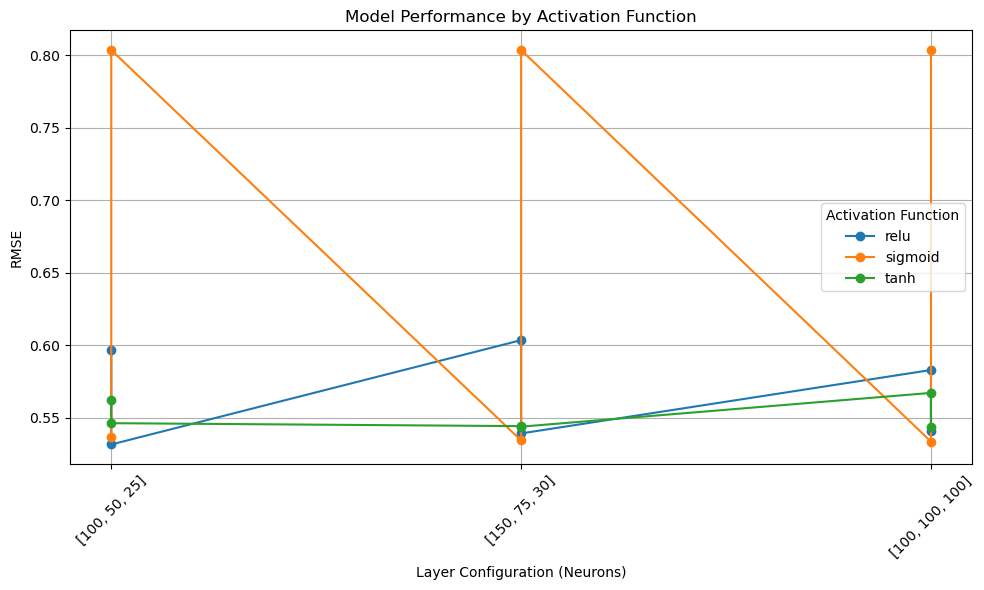

In [3]:
''' 
Tuning the following hyperparameters when training neural networks using Tensorflow and
tabulate all the results of each model on how they affect performance in your report. Also,
save all the models you have tried as a proof in your notebook.
• Activation: relu, sigmoid, tanh
• Number of layers and neuron count for each layer
• Optimizer: adam and sgd. 
'''

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50, 25], [150, 75, 30], [100, 100, 100]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart
plot(results_df)